# Prophet Model

In [20]:
# imports 
import json
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from prophet.plot import add_changepoints_to_plot

In [21]:
# load data
df_train = pd.read_csv("../../dataset/processed/train/train.csv")
df_test = pd.read_csv("../../dataset/processed/test/test.csv")

print(df_train.head())

                  time  fossil_fuels  windpower  solarpower  \
0  2014-12-31 23:00:00       10156.0     6378.0        49.0   
1  2015-01-01 00:00:00       10437.0     5890.0        50.0   
2  2015-01-01 01:00:00        9918.0     5461.0        50.0   
3  2015-01-01 02:00:00        8859.0     5238.0        50.0   
4  2015-01-01 03:00:00        8313.0     4935.0        42.0   

   other_green_energy  total_load_actual  price_day_ahead  price_actual  \
0              3709.0            25385.0            50.10         65.41   
1              3425.0            24382.0            48.10         64.92   
2              3104.0            22734.0            47.33         64.48   
3              2475.0            21286.0            42.27         59.32   
4              2407.0            20264.0            38.41         56.04   

   day_of_week  hour_of_day  
0          2.0         23.0  
1          3.0         12.0  
2          3.0          1.0  
3          3.0          2.0  
4          3.0      

## Data processing

As Prophet requires the input data to be in a specific format, we need to preprocess the data before fitting the model. Specifically, we need to rename the columns to 'ds' and 'y' for the date and target columns, respectively. We also need to convert the date column to a datetime object.

In [22]:
# rename columns
df_train = df_train.rename(columns={"time": "ds", "price_actual": "y"})
df_test = df_test.rename(columns={"time": "ds", "price_actual": "y"})

# format date 
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d %H:%M:%S')

print(df_train.head())

                   ds  fossil_fuels  windpower  solarpower  \
0 2014-12-31 23:00:00       10156.0     6378.0        49.0   
1 2015-01-01 00:00:00       10437.0     5890.0        50.0   
2 2015-01-01 01:00:00        9918.0     5461.0        50.0   
3 2015-01-01 02:00:00        8859.0     5238.0        50.0   
4 2015-01-01 03:00:00        8313.0     4935.0        42.0   

   other_green_energy  total_load_actual  price_day_ahead      y  day_of_week  \
0              3709.0            25385.0            50.10  65.41          2.0   
1              3425.0            24382.0            48.10  64.92          3.0   
2              3104.0            22734.0            47.33  64.48          3.0   
3              2475.0            21286.0            42.27  59.32          3.0   
4              2407.0            20264.0            38.41  56.04          3.0   

   hour_of_day  
0         23.0  
1         12.0  
2          1.0  
3          2.0  
4          3.0  


## Model creation

Next, we will create the model using the Prophet class. All features will be added as regressors, and the model will be fitted to the training data.

In [8]:
def create_model(model_config, regressors):
	model = Prophet(**model_config)
	for regressor in regressors:
		model.add_regressor(regressor)
	return model

# all other columns that are not ds or y or price_day_ahead  are regressors
regressors = df_train.columns.difference(['ds', 'y', 'price_day_ahead'])

model_config = {}

model = create_model(model_config, regressors)	

## Fit model

In [5]:
model.fit(df_train)

09:38:25 - cmdstanpy - INFO - Chain [1] start processing
09:39:15 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# save
with open("model.json", "w") as fout:
	json.dump(model_to_json(model), fout)

## Make predictions

In [23]:
# (optional) load model
with open("model.json", "r") as fin:
	model = model_from_json(json.load(fin))

In [24]:
# df_test = df_test.drop(columns=['price_day_ahead', 'y'])
print(df_test.head())


                    ds  fossil_fuels  windpower  solarpower  \
0  2018-03-14 18:00:00        6732.0    14265.0        31.0   
1  2018-03-14 19:00:00        6769.0    13306.0        27.0   
2  2018-03-14 20:00:00        5723.0    12970.0        17.0   
3  2018-03-14 21:00:00        5360.0    13090.0        17.0   
4  2018-03-14 22:00:00        4908.0    13408.0        17.0   

   other_green_energy  total_load_actual  price_day_ahead      y  day_of_week  \
0              8930.0            35044.0            37.61  50.95          2.0   
1              9275.0            36230.0            48.21  59.73          2.0   
2              8663.0            35065.0            41.11  50.89          2.0   
3              7900.0            32328.0            36.72  45.94          2.0   
4              7747.0            29528.0            21.20  30.59          2.0   

   hour_of_day  
0         18.0  
1         19.0  
2         20.0  
3         21.0  
4         22.0  


In [25]:
forecast = model.predict(df_test)

In [26]:
yhat = forecast['yhat']


In [31]:
df_test['y']

0       50.95
1       59.73
2       50.89
3       45.94
4       30.59
        ...  
7008    77.02
7009    76.16
7010    74.30
7011    69.89
7012    69.88
Name: y, Length: 7013, dtype: float64

C:\Users\Andreas\AppData\Local\Temp\ipykernel_16472\3067225023.py:4: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



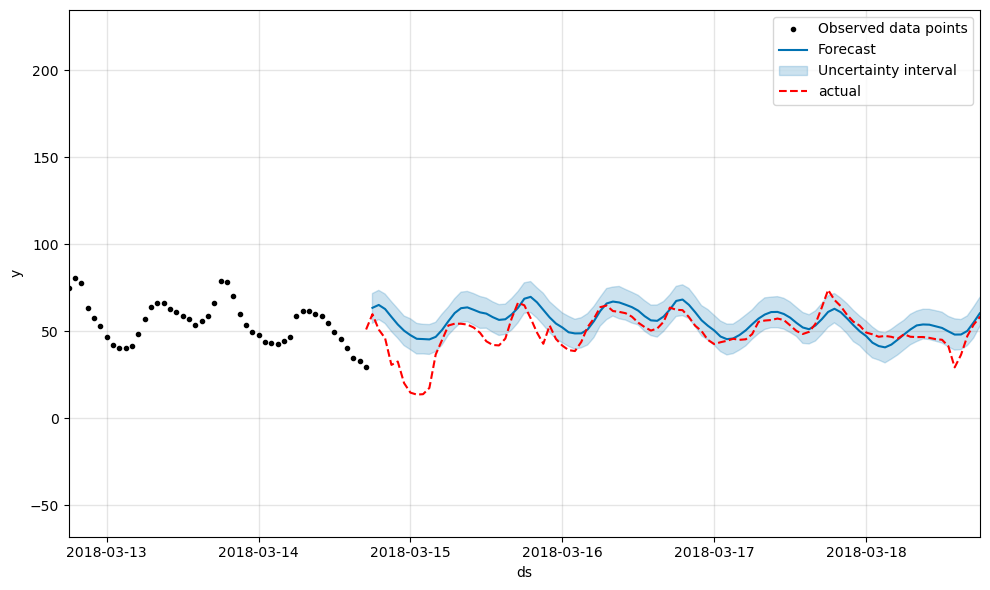

In [51]:
fig = model.plot(forecast)

# plot the actual data
test_x = pd.date_range(start=df_train['ds'].max(), periods=len(df_test), freq='H')
plt.plot(test_x, df_test['y'], '--r', label='actual')

plt.xlim([forecast['ds'].min() - pd.Timedelta(days=2), forecast['ds'].min() + pd.Timedelta(days=4)])
plt.legend()
plt.show()